# Processing different file types with TF

Processing CSV files with TensorFlow.

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [3]:
# load the data from GOOGLE's

TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file('train.csv', TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file('eval.csv', TEST_DATA_URL)

print(train_file_path)

24576/13049 [========================================================] - 0s 3us/step
C:\Users\DELL\.keras\datasets\train.csv


In [4]:
titanic_df = pd.read_csv(train_file_path, header='infer')
titanic_df.head(5)

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [8]:
titanic_df.describe().T

,count,mean,std,min,25%,50%,75%,max
survived,627.0,0.387560,0.487582,0.00,0.0000,0.0000,1.0000,1.0000
age,627.0,29.631308,12.511818,0.75,23.0000,28.0000,35.0000,80.0000
n_siblings_spouses,627.0,0.545455,1.151090,0.00,0.0000,0.0000,1.0000,8.0000
parch,627.0,0.379585,0.792999,0.00,0.0000,0.0000,0.0000,5.0000
fare,627.0,34.385399,54.597730,0.00,7.8958,15.0458,31.3875,512.3292


In [26]:
# read CSV data with TF
LABEL_COLUMN = 'survived'
LABELS = [0, 1]

train_ds = tf.data.experimental.make_csv_dataset(
    train_file_path, batch_size=3, label_name=LABEL_COLUMN, na_value='?',
    num_epochs=1, ignore_errors=True
)

test_ds = tf.data.experimental.make_csv_dataset(
    test_file_path, batch_size=3, label_name=LABEL_COLUMN, na_value='?',
    num_epochs=1, ignore_errors=True
)

In [28]:
# displaying a Batch of dataset
for batch, label in train_ds.take(1):
    print(label)
    for key, value in batch.items():
        print("{}: {}".format(key, value.numpy()))



tf.Tensor([1 0 0], shape=(3,), dtype=int32)
sex: [b'female' b'male' b'female']
age: [30. 28. 23.]
n_siblings_spouses: [0 0 0]
parch: [0 0 0]
fare: [106.425   7.25    7.925]
class: [b'First' b'Third' b'Third']
deck: [b'unknown' b'unknown' b'unknown']
embark_town: [b'Cherbourg' b'Southampton' b'Southampton']
alone: [b'y' b'y' b'y']


In [29]:
# designate columns with Feature-columns
feature_columns = []

# numeric columns
for header in ['age', 'n_siblings_spouses', 'parch', 'fare']:
    feature_columns.append(tf.feature_column.numeric_column(header))


# binning the AGE column based on the quartiles in DESC above
age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[23, 28, 35])

# checking the Unique values in the Categorical values
h = {}
for col in titanic_df:
    if col in ['sex', 'class', 'deck', 'embark_town', 'alone']:
        print(col, ': ', titanic_df[col].unique())
        h[col] = titanic_df[col].unique()


sex :  ['male' 'female']
class :  ['Third' 'First' 'Second']
deck :  ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town :  ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone :  ['n' 'y']


In [62]:
age_buckets

# no of Buckets = 4

BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(23, 28, 35))

In [30]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='n_siblings_spouses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='parch', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [31]:
# how to enocde CAT columns & OHE it
sex_type = tf.feature_column.categorical_column_with_vocabulary_list(
    key='Type', vocabulary_list=['male', 'female']
)
sex_type_one_hot = tf.feature_column.indicator_column(sex_type)


In [63]:
sex_type_one_hot

IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Type', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0))

In [32]:
# a better way to encode categorical values
sex_type = tf.feature_column.categorical_column_with_vocabulary_list(
    'Type', h.get('sex').tolist()
)
sex_type_one_hot = tf.feature_column.indicator_column(sex_type)


class_type = tf.feature_column.categorical_column_with_vocabulary_list(
    'Type', h.get('class').tolist()
)
class_type_one_hot = tf.feature_column.indicator_column(class_type)

deck_type = tf.feature_column.categorical_column_with_vocabulary_list(
    'Type', h.get('deck').tolist()
)
deck_type_one_hot = tf.feature_column.indicator_column(deck_type)

embark_town_type = tf.feature_column.categorical_column_with_vocabulary_list(
    'Type', h.get('embark_town').tolist()
)
embark_town_type_one_hot = tf.feature_column.indicator_column(embark_town_type)

alone_type = tf.feature_column.categorical_column_with_vocabulary_list(
    'Type', h.get('alone').tolist()
)
alone_type_one_hot = tf.feature_column.indicator_column(alone_type)


# DECK column has 8 unique value more than others, so reduce to 3 dimenstions
deck = tf.feature_column.categorical_column_with_vocabulary_list(
    'deck', titanic_df.deck.unique()
)
deck_embedding = tf.feature_column.embedding_column(deck, dimension=3)

# another way to reduce dimension
class_hashed = tf.feature_column.categorical_column_with_hash_bucket(
    'class', hash_bucket_size=4
)

In [33]:
# how to create a HASH Bucket
cross_type_feature = tf.feature_column.crossed_column(['sex', 'class'], hash_bucket_size=5)
feature_columns = [] # list to hold features to use

# append numeric columns
for header in ['age', 'n_siblings_spouses', 'parch', 'fare']:
    feature_columns.append(tf.feature_column.numeric_column(header))

age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[23, 28, 35])
feature_columns.append(age_buckets)

# append categorical columns
indicator_column_names = ['sex', 'class', 'deck', 'embark_town', 'alone']
for col_name in indicator_column_names:
    categorical_column = tf.feature_column.categorical_column_with_vocabulary_list(
        col_name, titanic_df[col_name].unique()
    )
    indicator_column = tf.feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)

# append embedding columns
deck = tf.feature_column.categorical_column_with_vocabulary_list(
    'deck', titanic_df.deck.unique()
)
deck_embedding = tf.feature_column.embedding_column(deck, dimension=3)
feature_columns.append(deck_embedding)

# append crossed columns
feature_columns.append(tf.feature_column.indicator_column(cross_type_feature))


In [41]:
# read the CSV files
train_df = pd.read_csv(r'C:\Users\DELL\.keras\datasets\train.csv')
test_df = pd.read_csv(r'C:\Users\DELL\.keras\datasets\eval.csv')

In [43]:
# now create a Feature Layer which would serve as the first input layer
feature_layer = layers.DenseFeatures(feature_columns)

val_df, test_df = train_test_split(test_df, test_size=0.4)
batch_size = 32
labels = train_df.pop('survived')
working_ds = tf.data.Dataset.from_tensor_slices((dict(train_df), labels))
working_ds = working_ds.shuffle(buffer_size=len(train_df))
train_ds = working_ds.batch(batch_size)


In [46]:
# functino to convert Pandas DF to Tensor slices
def pandas_to_dataset(df, shuffle=True, batch_size=32):
    df = df.copy()
    labels = df.pop('survived')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(batch_size=len(df))
    ds = ds.batch(batch_size)
    return ds

In [49]:
val_ds = pandas_to_dataset(val_df, shuffle=False, batch_size=batch_size)
test_ds = pandas_to_dataset(test_df, shuffle=False, batch_size=batch_size)


In [53]:
import warnings

warnings.simplefilter('ignore')

In [54]:
# model training Process
model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(1)
])
model.compile(
    optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
 1/20 [>.............................] - ETA: 34s - loss: 7.3403 - accuracy: 0.5000WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'sex': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=string>, 'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'n_siblings_spouses': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=int64>, 'parch': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=int64>, 'fare': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=float64>, 'class': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>, 'deck': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'embark_town': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=string>, 'alone': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>}
Consider rewriting this model with the Functi

Processing Image files with TensorFlow

In [2]:
import pathlib
import matplotlib.pylab as plt
import os, pickle

from tensorflow.keras import Sequential
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tensorflow and numpy

In [3]:
# get the Images
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True
)

In [4]:
# function to display the Image
def display_image_in_actual_size(im_path):
    dpi = 100
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(im_data, cmap='gray')
    plt.show()

In [9]:
data_dir

'C:\\Users\\DELL\\.keras\\datasets\\flower_photos'

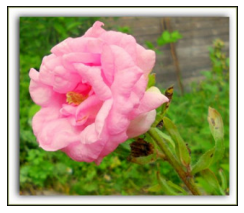

In [20]:
base_path = r'C:\Users\DELL\.keras\datasets\flower_photos'
# roses_path = os.path.join(data_dir, r'\flower_photos\roses')
# daisy_path = os.path.join(data_dir, r'\flower_photos\daisy')

IMAGE_PATH = r'C:\Users\DELL\.keras\datasets\flower_photos\roses\7409458444_0bfc9a0682_n.jpg'
display_image_in_actual_size(IMAGE_PATH)

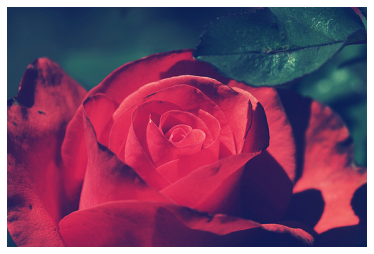

In [21]:
# showing the different dimensions in the images
IMAGE_PATH = r'C:\Users\DELL\.keras\datasets\flower_photos\roses\5736328472_8f25e6f6e7.jpg'
display_image_in_actual_size(IMAGE_PATH)

In [23]:
pixels, BATCH_SIZE = 224, 32
IMAGE_SIZE = (pixels, pixels)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, interpolation='bilinear')

# training data 
my_datagen = ImageDataGenerator(**datagen_kwargs)
my_generator = my_datagen.flow_from_directory(data_dir, **dataflow_kwargs)

# validation data
valid_datagen = ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset='validation', shuffle=False, **dataflow_kwargs
)

Found 3670 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [24]:
for image_batch, labels_batch in my_generator:
    # prints the first batch out
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 5)


In [28]:
labels_idx = (my_generator.class_indices)
idx_labels = dict((v, k) for k, v in labels_idx.items())
print(idx_labels)

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}


In [30]:
# save the label index for LOOKUP 
with open('prediction_lookup.pickle', 'wb') as handle:
    pickle.dump(idx_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

# how to load the model back
with open('prediction_lookup.pickle', 'rb') as handle:
    lookup = pickle.load(handle)
    

In [35]:
# training the Model with a pretrained ResNet feature vector
NUM_CLASSES = 5
mdl = Sequential([
    layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer('https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/4',
    trainable=False),
    layers.Dense(NUM_CLASSES, activation='softmax', name='custom_class')
])
mdl.build([None, 224, 224, 3])

In [36]:
mdl.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              42605504  
_________________________________________________________________
custom_class (Dense)         (None, 5)                 10245     
Total params: 42,615,749
Trainable params: 10,245
Non-trainable params: 42,605,504
_________________________________________________________________


In [38]:
mdl.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits=True, label_smoothing=0.1
    ),
    metrics=['accuracy']
)

steps_per_epoch = my_generator.samples // my_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

In [39]:
mdl.fit(
    my_generator, epochs=5, steps_per_epoch=steps_per_epoch, validation_data=valid_generator,
    validation_steps=validation_steps
)

Epoch 1/5


C:\Users\DELL\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


114/114 [==============================] - 671s 6s/step - loss: 0.9132 - accuracy: 0.8057 - val_loss: 0.6848 - val_accuracy: 0.9020
Epoch 2/5
114/114 [==============================] - 635s 6s/step - loss: 0.6447 - accuracy: 0.9027 - val_loss: 0.5980 - val_accuracy: 0.9403
Epoch 3/5
114/114 [==============================] - 626s 5s/step - loss: 0.5824 - accuracy: 0.9447 - val_loss: 0.5743 - val_accuracy: 0.9531
Epoch 4/5
114/114 [==============================] - 604s 5s/step - loss: 0.5549 - accuracy: 0.9566 - val_loss: 0.5191 - val_accuracy: 0.9801
Epoch 5/5
114/114 [==============================] - 594s 5s/step - loss: 0.5286 - accuracy: 0.9714 - val_loss: 0.5169 - val_accuracy: 0.9744


Working with Text File

In [40]:
import time

In [41]:
FILE_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'
FILE_NAME = 'shakespeare.txt'
path_to_file = tf.keras.utils.get_file('shakespeare.txt', FILE_URL)

1130496/1115394 [==============================] - 1s 1us/step


In [42]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [43]:
# inspect text
print(text[:400])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 


In [48]:
vocabulary = sorted(set(text.lower()))
print('There are {} unique characters'.format(len(vocabulary)))

There are 39 unique characters


In [49]:
# glimpse of the vocabulary
vocabulary[:20]

['\n',
 ' ',
 '!',
 '$',
 '&',
 "'",
 ',',
 '-',
 '.',
 '3',
 ':',
 ';',
 '?',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g']

In [50]:
vocabulary_word = sorted(set(text.lower().split(' ')))
print ('There are {} unique words'.format(len(vocabulary_word)))

There are 41623 unique words


In [ ]:

# check out Sentinent Analysis project


